In [2]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, Input, \
    concatenate, Activation
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define class labels for binary classification
CLASS_NAMES = {
    0: "hemorrhage",  # Combined all hemorrhage types
    1: "normal"       # Normal class
}


In [3]:
def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ",
              subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image


def find_matching_image_paths(bone_folder, brain_folder, subdural_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path))

    return matching_image_paths


def load_image(file_path):
    """
    Load an image file, decode it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg depending on your files
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def load_and_preprocess_image(file_path, target_size=(256, 256)):
    """
    Load an image file, decode it, resize it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg

    # Resize to smaller dimensions to save memory
    img = tf.image.resize(img, target_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_path(bone_path, brain_path, subdural_path, label, target_size=(256, 256)):
    # Load and resize the images
    bone_img = load_and_preprocess_image(bone_path, target_size)
    brain_img = load_and_preprocess_image(brain_path, target_size)
    subdural_img = load_and_preprocess_image(subdural_path, target_size)

    # Apply contrast enhancement
    bone_img = tf.image.adjust_contrast(bone_img, 1.5)
    brain_img = tf.image.adjust_contrast(brain_img, 1.5)
    subdural_img = tf.image.adjust_contrast(subdural_img, 1.5)

    # Ensure normalization is consistent
    bone_img = tf.clip_by_value(bone_img, 0.0, 1.0)
    brain_img = tf.clip_by_value(brain_img, 0.0, 1.0)
    subdural_img = tf.clip_by_value(subdural_img, 0.0, 1.0)

    # Stack the images
    image = tf.concat([bone_img, brain_img, subdural_img], axis=-1)

    return image, label


def prepare_path_and_label_lists_binary():
    """
    Prepare lists of file paths and corresponding labels for binary classification.
    """
    # List of folder prefixes for each class
    hemorrhage_folders = ["epidural", "intraparenchymal", "intraventricular", "multi", "subarachnoid", "subdural"]
    normal_folder = "normal"

    all_bone_paths = []
    all_brain_paths = []
    all_subdural_paths = []
    all_labels = []

    # Use a smaller number for each class to reduce memory usage
    min_hem_type = 1013  # Reduced from 1000
    min_normal_type = 6*min_hem_type

    # Process all hemorrhage types (label 0)
    for prefix in hemorrhage_folders:
        bone_folder = f'renders/{prefix}/brain_bone_window'
        brain_folder = f'renders/{prefix}/brain_window'
        subdural_folder = f'renders/{prefix}/subdural_window'

        matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder)
        selected_paths = matching_paths[:min_hem_type]  # Limit samples per hemorrhage type

        for bone_path, brain_path, subdural_path in selected_paths:
            all_bone_paths.append(bone_path)
            all_brain_paths.append(brain_path)
            all_subdural_paths.append(subdural_path)
            all_labels.append(0)  # 0 = hemorrhage

        print("Type: ", prefix, "\tTotal Possible Images: ", len(matching_paths), "\tSelected: ", len(selected_paths))

    # Process normal cases (label 1)
    bone_folder = f'renders/{normal_folder}/brain_bone_window'
    brain_folder = f'renders/{normal_folder}/brain_window'
    subdural_folder = f'renders/{normal_folder}/subdural_window'

    matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder)

    # Option 1: To keep balanced classes, use same number of normal cases as hemorrhage cases
    total_hemorrhage = len(all_labels)
    selected_paths = matching_paths[:total_hemorrhage]

    # Option 2: Or use min_num_type for normal cases as well
    # selected_paths = matching_paths[:min_num_type]

    for bone_path, brain_path, subdural_path in selected_paths:
        all_bone_paths.append(bone_path)
        all_brain_paths.append(brain_path)
        all_subdural_paths.append(subdural_path)
        all_labels.append(1)  # 1 = normal

    return all_bone_paths, all_brain_paths, all_subdural_paths, all_labels


def configure_for_performance(ds, batch_size=8, buffer_size=1000, shuffle=True):
    """
    Configure dataset for performance with reduced batch size.
    """
    # Shuffle if needed
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size)

    # Use smaller batch size
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


def create_hemorrhage_datasets(batch_size=8, validation_split=0.2, test_split=0.1,
                               target_size=(256, 256), seed=42):
    """
    Create train, validation, and test datasets with memory optimizations.
    """
    # Get file paths and labels
    bone_paths, brain_paths, subdural_paths, labels = prepare_path_and_label_lists_binary()

    # Convert to tensors
    bone_paths = tf.convert_to_tensor(bone_paths)
    brain_paths = tf.convert_to_tensor(brain_paths)
    subdural_paths = tf.convert_to_tensor(subdural_paths)
    labels = tf.convert_to_tensor(labels)

    # Calculate dataset sizes
    dataset_size = len(labels)
    test_size = int(test_split * dataset_size)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size - test_size

    # Create full dataset
    full_dataset = tf.data.Dataset.from_tensor_slices((bone_paths, brain_paths, subdural_paths, labels))

    # Shuffle
    full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=seed)

    # Split into train, validation, and test
    train_ds = full_dataset.take(train_size)
    remaining_ds = full_dataset.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    # Map to process the data with resizing
    train_ds = train_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_ds = test_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Configure datasets for performance with smaller batch size
    train_ds = configure_for_performance(train_ds, batch_size=batch_size, shuffle=True)
    val_ds = configure_for_performance(val_ds, batch_size=batch_size, shuffle=False)
    test_ds = configure_for_performance(test_ds, batch_size=batch_size, shuffle=False)

    return train_ds, val_ds, test_ds


def build_unet_classifier_with_pretrained_encoder(input_shape=(256, 256, 3), num_classes=2, encoder_type='resnet50',
                                                  pretrained=True):
    """
    Build U-Net with a pre-trained encoder backbone for classification tasks

    Args:
        input_shape: Input shape of the images
        num_classes: Number of classes for classification
        encoder_type: 'resnet50' or 'xception'
        pretrained: Whether to use pre-trained weights (True) or random initialization (False)

    Returns:
        U-Net model adapted for classification tasks
    """
    inputs = Input(shape=input_shape)

    # Select pre-trained encoder
    if encoder_type == 'resnet50':
        weights = 'imagenet' if pretrained else None
        base_model = ResNet50(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('conv1_relu').output  # 256x256
        s2 = base_model.get_layer('conv2_block3_out').output  # 128x128
        s3 = base_model.get_layer('conv3_block4_out').output  # 64x64
        s4 = base_model.get_layer('conv4_block6_out').output  # 32x32

        # Bridge
        bridge = base_model.get_layer('conv5_block3_out').output  # 16x16

    elif encoder_type == 'xception':
        weights = 'imagenet' if pretrained else None
        base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('block2_sepconv2_bn').output  # 128x128
        s2 = base_model.get_layer('block3_sepconv2_bn').output  # 64x64
        s3 = base_model.get_layer('block4_sepconv2_bn').output  # 32x32
        s4 = base_model.get_layer('block13_sepconv2_bn').output  # 16x16

        # Bridge
        bridge = base_model.get_layer('block14_sepconv2_bn').output  # 16x16
    else:
        raise ValueError(f"Unsupported encoder type: {encoder_type}. Choose 'resnet50' or 'xception'")

    # Decoder path - but with fewer upsampling blocks for classification
    # First upsampling block
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Dropout(0.3)(u1)

    # Second upsampling block
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Dropout(0.3)(u2)

    # Global average pooling for classification
    gap = GlobalAveragePooling2D()(u2)

    # Classification head
    x = Dense(256, activation='relu')(gap)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Change this in your model architecture

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def set_encoder_trainable(model, trainable=False):
    """
    Set trainable property of the encoder layers

    Args:
        model: The U-Net model with pre-trained encoder
        trainable: Whether to make encoder layers trainable (True) or frozen (False)
    """
    # Find the pre-trained backbone layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):  # This is the base model
            for base_layer in layer.layers:
                base_layer.trainable = trainable

    return model


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=2,
    encoder_type='resnet50',
    pretrained=True
)

Type:  epidural 	Total Possible Images:  1694 	Selected:  1013
Type:  intraparenchymal 	Total Possible Images:  15664 	Selected:  1013
Type:  intraventricular 	Total Possible Images:  9878 	Selected:  1013
Type:  multi 	Total Possible Images:  32074 	Selected:  1013
Type:  subarachnoid 	Total Possible Images:  16423 	Selected:  1013
Type:  subdural 	Total Possible Images:  32200 	Selected:  1013


In [ ]:

# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'classifier_2_class_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen encoder
fine_tune_history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[early_stopping, model_checkpoint]
)

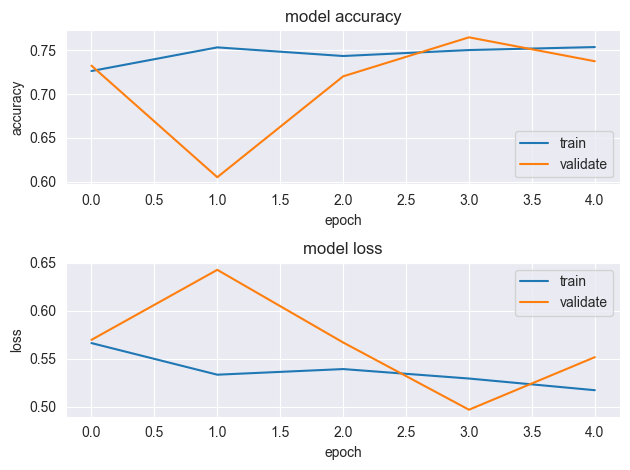

In [10]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [11]:
# Evaluate the model on test data
unet_classifier.load_weights('classifier_2_class_best.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 145s 910ms/step - accuracy: 0.7314 - loss: 0.5390
Test accuracy: 0.7202


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

def evaluate_and_visualize_confusion_matrix(model, test_dataset, class_names, title="Confusion Matrix"):
    """
    Evaluate a model on test data and visualize the confusion matrix

    Args:
        model: Trained Keras model
        test_dataset: tf.data.Dataset containing test data
        class_names: Dictionary mapping class indices to class names
        title: Title for the confusion matrix plot
    """
    # Get predictions and true labels
    y_pred_list = []
    y_true_list = []

    # Get predictions in batches
    for x_batch, y_batch in test_dataset:
        y_pred = model.predict(x_batch)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_pred_list.extend(y_pred_classes)
        y_true_list.extend(y_batch.numpy())

    y_pred_array = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_array, y_pred_array)

    # Create class labels list from the dictionary
    class_labels = [class_names[i] for i in range(len(class_names))]

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true_array, y_pred_array,
                                target_names=class_labels))

    # Calculate overall accuracy
    accuracy = np.sum(y_pred_array == y_true_array) / len(y_true_array)
    print(f"Overall Accuracy: {accuracy:.4f}")

    return cm

In [5]:
def check_dataset_balance(dataset):
    """Count the number of samples per class in a TensorFlow dataset"""
    hemorrhage_count = 0
    normal_count = 0

    # Iterate through the dataset
    for _, labels in dataset:
        # Convert one-hot encoded labels back to integers if needed
        if len(labels.shape) > 1:
            # If labels are batched and one-hot encoded
            batch_labels = tf.argmax(labels, axis=-1).numpy()
        else:
            # If labels are just integers
            batch_labels = labels.numpy()

        # Count instances of each class
        hemorrhage_count += np.sum(batch_labels == 0)
        normal_count += np.sum(batch_labels == 1)

    return {
        "hemorrhage": hemorrhage_count,
        "normal": normal_count,
        "total": hemorrhage_count + normal_count,
        "ratio": f"1:{normal_count/hemorrhage_count:.2f}" if hemorrhage_count > 0 else "N/A"
    }

In [14]:

# Check balance in each dataset
train_balance = check_dataset_balance(train_ds)
val_balance = check_dataset_balance(val_ds)
test_balance = check_dataset_balance(test_ds)

print("Training dataset balance:")
print(f"Hemorrhage: {train_balance['hemorrhage']}")
print(f"Normal: {train_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {train_balance['ratio']}")
print()

print("Validation dataset balance:")
print(f"Hemorrhage: {val_balance['hemorrhage']}")
print(f"Normal: {val_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {val_balance['ratio']}")
print()

print("Test dataset balance:")
print(f"Hemorrhage: {test_balance['hemorrhage']}")
print(f"Normal: {test_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {test_balance['ratio']}")

Training dataset balance:
Hemorrhage: 6912
Normal: 4262
Ratio (hemorrhage:normal): 1:0.62

Validation dataset balance:
Hemorrhage: 2012
Normal: 1180
Ratio (hemorrhage:normal): 1:0.59

Test dataset balance:
Hemorrhage: 989
Normal: 607
Ratio (hemorrhage:normal): 1:0.61


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

Type:  epidural 	Total Possible Images:  1694 	Selected:  1013
Type:  intraparenchymal 	Total Possible Images:  15664 	Selected:  1013
Type:  intraventricular 	Total Possible Images:  9878 	Selected:  1013
Type:  multi 	Total Possible Images:  32074 	Selected:  1013
Type:  subarachnoid 	Total Possible Images:  16423 	Selected:  1013
Type:  subdural 	Total Possible Images:  32200 	Selected:  1013


In [6]:
# Check balance in each dataset
train_balance = check_dataset_balance(train_ds)
val_balance = check_dataset_balance(val_ds)
test_balance = check_dataset_balance(test_ds)

print("Training dataset balance:")
print(f"Hemorrhage: {train_balance['hemorrhage']}")
print(f"Normal: {train_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {train_balance['ratio']}")
print()

print("Validation dataset balance:")
print(f"Hemorrhage: {val_balance['hemorrhage']}")
print(f"Normal: {val_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {val_balance['ratio']}")
print()

print("Test dataset balance:")
print(f"Hemorrhage: {test_balance['hemorrhage']}")
print(f"Normal: {test_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {test_balance['ratio']}")

Training dataset balance:
Hemorrhage: 4245
Normal: 4265
Ratio (hemorrhage:normal): 1:1.00

Validation dataset balance:
Hemorrhage: 1189
Normal: 1242
Ratio (hemorrhage:normal): 1:1.04

Test dataset balance:
Hemorrhage: 605
Normal: 610
Ratio (hemorrhage:normal): 1:1.01


In [8]:
# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=2,
    encoder_type='resnet50',
    pretrained=True
)

# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'classifier_2_class_best_3.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Epoch 1/3
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6581 - loss: 0.6216

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 3512s 3s/step - accuracy: 0.6581 - loss: 0.6216 - val_accuracy: 0.5072 - val_loss: 1.4050
Epoch 2/3
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 3467s 3s/step - accuracy: 0.6776 - loss: 0.5926 - val_accuracy: 0.4986 - val_loss: 2.0420
Epoch 3/3
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 3558s 3s/step - accuracy: 0.7054 - loss: 0.5665 - val_accuracy: 0.5035 - val_loss: 1.6011


In [ ]:

"""# Continue training with unfrozen encoder
fine_tune_history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[early_stopping, model_checkpoint]
)"""

In [10]:
# Evaluate the model on test data
unet_classifier.load_weights('classifier_2_class_best_3.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 128s 810ms/step - accuracy: 0.4897 - loss: 1.4643
Test accuracy: 0.5128


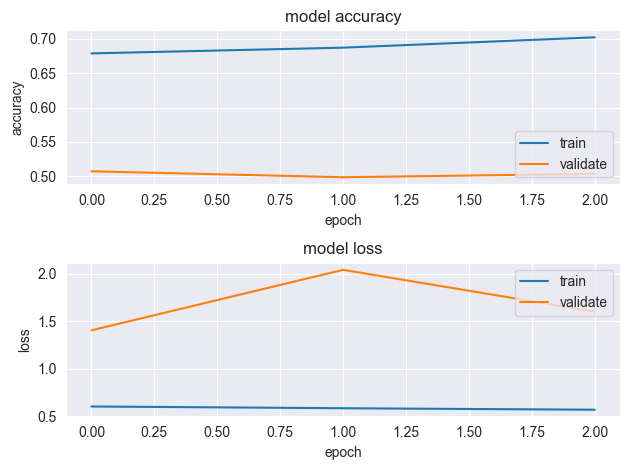

In [14]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [ ]:
cm_2class = evaluate_and_visualize_confusion_matrix(
    unet_classifier,
    train_ds,
    CLASS_NAMES,
    title="2-Class Hemorrhage Classification Confusion Matrix"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [6]:
def evaluate_and_visualize_confusion_matrix(model, test_dataset, class_names, title="Confusion Matrix"):
    """
    Evaluate a model on test data and visualize the confusion matrix

    Args:
        model: Trained Keras model
        test_dataset: tf.data.Dataset containing test data
        class_names: Dictionary mapping class indices to class names
        title: Title for the confusion matrix plot
    """
    # Get predictions and true labels
    y_pred_list = []
    y_true_list = []

    # Get predictions in batches
    for x_batch, y_batch in test_dataset:
        y_pred = model.predict(x_batch)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_pred_list.extend(y_pred_classes)
        y_true_list.extend(y_batch.numpy())

    y_pred_array = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_array, y_pred_array)

    # Create class labels list from the dictionary
    class_labels = [class_names[i] for i in range(len(class_names))]

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true_array, y_pred_array,
                                target_names=class_labels))

    # Calculate overall accuracy
    accuracy = np.sum(y_pred_array == y_true_array) / len(y_true_array)
    print(f"Overall Accuracy: {accuracy:.4f}")

    return cm

y_true length: 1215
y_pred length: 1215


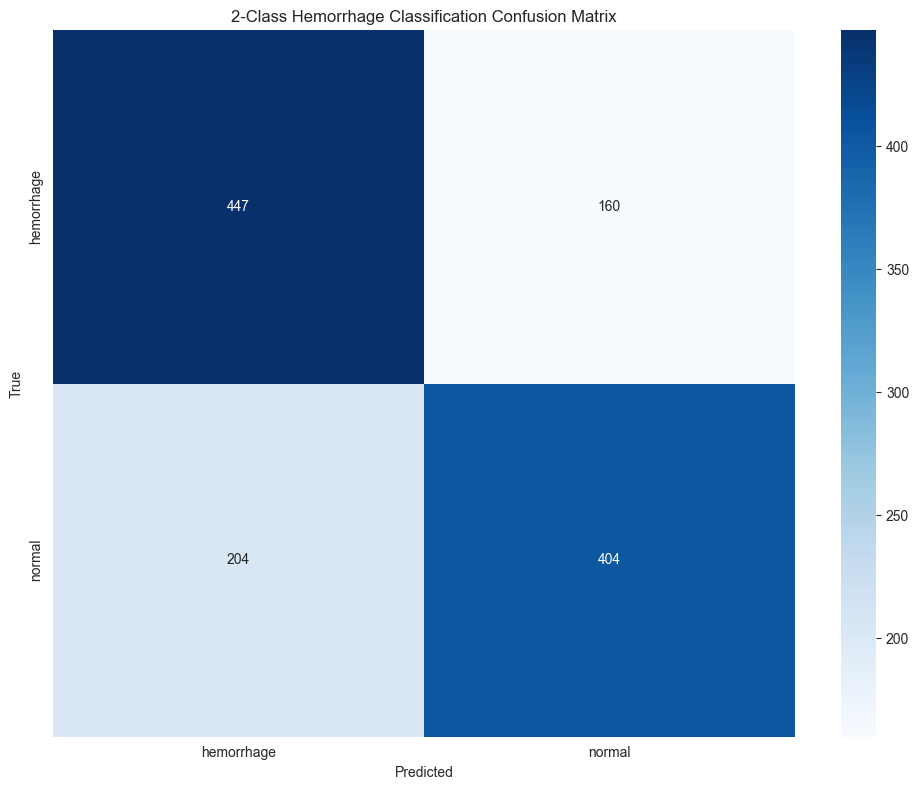


Classification Report:

              precision    recall  f1-score   support

  hemorrhage       0.69      0.74      0.71       607
      normal       0.72      0.66      0.69       608

    accuracy                           0.70      1215
   macro avg       0.70      0.70      0.70      1215
weighted avg       0.70      0.70      0.70      1215

Overall Accuracy: 0.7004


In [18]:
cm_2class = evaluate_and_visualize_confusion_matrix(
    unet_classifier,
    val_ds,
    CLASS_NAMES,
    title="2-Class Hemorrhage Classification Confusion Matrix"
)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

Type:  epidural 	Total Possible Images:  1694 	Selected:  1013
Type:  intraparenchymal 	Total Possible Images:  15664 	Selected:  1013
Type:  intraventricular 	Total Possible Images:  9878 	Selected:  1013
Type:  multi 	Total Possible Images:  32074 	Selected:  1013
Type:  subarachnoid 	Total Possible Images:  16423 	Selected:  1013
Type:  subdural 	Total Possible Images:  32200 	Selected:  1013


In [8]:
# Check balance in each dataset
train_balance = check_dataset_balance(train_ds)
val_balance = check_dataset_balance(val_ds)
test_balance = check_dataset_balance(test_ds)

print("Training dataset balance:")
print(f"Hemorrhage: {train_balance['hemorrhage']}")
print(f"Normal: {train_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {train_balance['ratio']}")
print()

print("Validation dataset balance:")
print(f"Hemorrhage: {val_balance['hemorrhage']}")
print(f"Normal: {val_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {val_balance['ratio']}")
print()

print("Test dataset balance:")
print(f"Hemorrhage: {test_balance['hemorrhage']}")
print(f"Normal: {test_balance['normal']}")
print(f"Ratio (hemorrhage:normal): {test_balance['ratio']}")

Training dataset balance:
Hemorrhage: 4245
Normal: 4265
Ratio (hemorrhage:normal): 1:1.00

Validation dataset balance:
Hemorrhage: 1189
Normal: 1242
Ratio (hemorrhage:normal): 1:1.04

Test dataset balance:
Hemorrhage: 605
Normal: 610
Ratio (hemorrhage:normal): 1:1.01


In [9]:
# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=2,
    encoder_type='xception',
    pretrained=True
)

In [9]:
# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'xception_2_class.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6756 - loss: 0.6063

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4558s 4s/step - accuracy: 0.6756 - loss: 0.6063 - val_accuracy: 0.6977 - val_loss: 0.6000
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7252 - loss: 0.5452

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4469s 4s/step - accuracy: 0.7252 - loss: 0.5452 - val_accuracy: 0.7524 - val_loss: 0.4883
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7347 - loss: 0.5316

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4498s 4s/step - accuracy: 0.7347 - loss: 0.5316 - val_accuracy: 0.7705 - val_loss: 0.4870
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7480 - loss: 0.5158

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4487s 4s/step - accuracy: 0.7480 - loss: 0.5158 - val_accuracy: 0.7775 - val_loss: 0.4625
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4440s 4s/step - accuracy: 0.7611 - loss: 0.4904 - val_accuracy: 0.7680 - val_loss: 0.4709
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4442s 4s/step - accuracy: 0.7629 - loss: 0.4882 - val_accuracy: 0.6096 - val_loss: 0.6580
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4489s 4s/step - accuracy: 0.7825 - loss: 0.4624 - val_accuracy: 0.7672 - val_loss: 0.4820
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4513s 4s/step - accuracy: 0.7830 - loss: 0.4519 - val_accuracy: 0.7445 - val_loss: 0.5138
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7902 - loss: 0.4413

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4478s 4s/step - accuracy: 0.7902 - loss: 0.4413 - val_accuracy: 0.8186 - val_loss: 0.4131
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 4453s 4s/step - accuracy: 0.8181 - loss: 0.4166 - val_accuracy: 0.8009 - val_loss: 0.4173


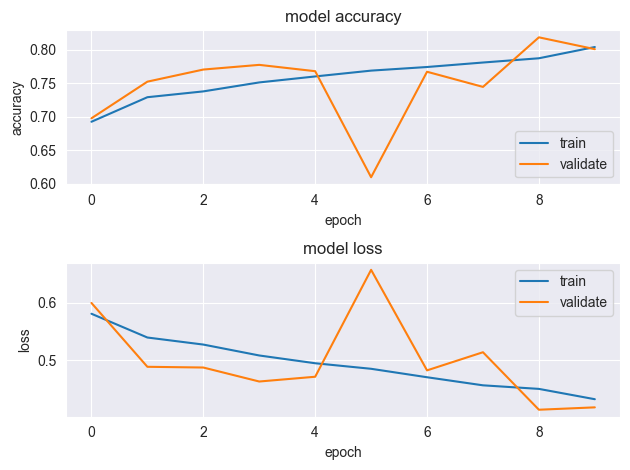

In [10]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [10]:
# Evaluate the model on test data
unet_classifier.load_weights('xception_2_class.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8045 - loss: 0.4300
Test accuracy: 0.8016


In [13]:
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8013 - loss: 0.4301
Test accuracy: 0.8025


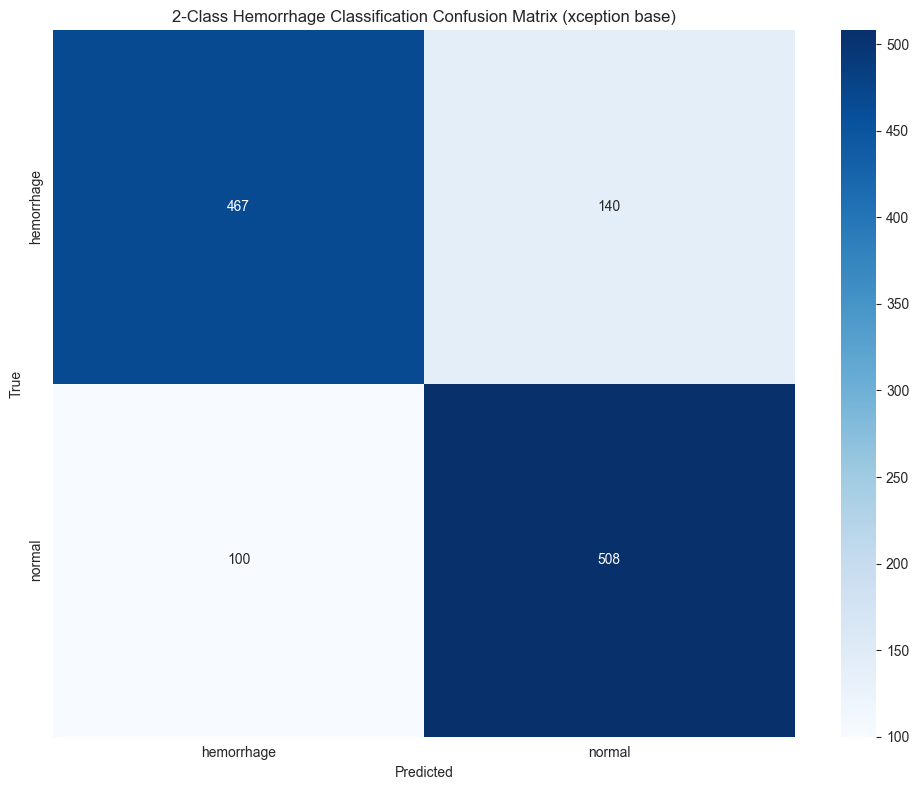


Classification Report:

              precision    recall  f1-score   support

  hemorrhage       0.82      0.77      0.80       607
      normal       0.78      0.84      0.81       608

    accuracy                           0.80      1215
   macro avg       0.80      0.80      0.80      1215
weighted avg       0.80      0.80      0.80      1215

Overall Accuracy: 0.8025


In [19]:
cm_2class = evaluate_and_visualize_confusion_matrix(
    unet_classifier,
    test_ds,
    CLASS_NAMES,
    title="2-Class Hemorrhage Classification Confusion Matrix"
)